15 minutes of execution

In [5]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


# 1. Load Dataset

# Load ONLY the clean/encoded dataset (must be fully numeric)
# Ensure this file contains no text (e.g., Gender, City) or that they are already encoded.
df = pd.read_csv("encoded_dataset.csv")  # Use the encoded file we saved earlier



# 2. Define Features and Target


# Remove 'Depression' (Target) from X to avoid data leakage (cheating).
# Remove 'id' if it exists, as it is not a predictive feature.
X = df.drop(columns=['Depression', 'id'], errors='ignore') 

# Define Target
y = df['Depression']

# Train/test split
# We use 'stratify=y' to keep the same proportion of Depressed/Non-Depressed cases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 3. Models to Test

models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    
    # n_jobs=-1 uses all CPU cores to speed up training
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    
    # SVM can be slow on large datasets. remove 'probability=True' if it's too slow.
    "SVM": SVC(probability=True, random_state=42),
    
    "k-NN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    
    "Naive Bayes": GaussianNB()
}


# 4. Scalers to Test

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler()
}



# 5. Experiment Loop

results = []

print("Starting training loop...")

for scaler_name, scaler in scalers.items():
    for model_name, model in models.items():
        try:
            # Create Pipeline: Scaler -> Model
            pipeline = Pipeline([
                ("scaler", scaler),
                ("classifier", model)
            ])
            
            # Train the model
            pipeline.fit(X_train, y_train)
            
            # Predict
            y_pred = pipeline.predict(X_test)
            
            # Handle predict_proba for models that support it (for ROC-AUC)
            if hasattr(pipeline['classifier'], "predict_proba"):
                y_proba = pipeline.predict_proba(X_test)[:,1]
            else:
                y_proba = None
            
            # Compute Metrics
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
            
            # Store results
            results.append({
                "Scaler": scaler_name,
                "Model": model_name,
                "Accuracy": round(acc, 4),
                "Precision": round(prec, 4),
                "Recall": round(rec, 4),
                "F1": round(f1, 4),
                "ROC-AUC": round(auc, 4)
            })
            print(f"Done: {scaler_name} + {model_name}")
            
        except Exception as e:
            print(f"Error with {scaler_name} + {model_name}: {e}")


# 6. Results Comparison

df_results = pd.DataFrame(results)

# Sort by F1-score to identify the best performing model
df_results = df_results.sort_values(by="F1", ascending=False)

print("\n--- Benchmark Results ---")
print(df_results)

Starting training loop...
Done: StandardScaler + Decision Tree
Done: StandardScaler + Random Forest
Done: StandardScaler + Logistic Regression
Done: StandardScaler + SVM
Done: StandardScaler + k-NN
Done: StandardScaler + Naive Bayes
Done: MinMaxScaler + Decision Tree
Done: MinMaxScaler + Random Forest
Done: MinMaxScaler + Logistic Regression
Done: MinMaxScaler + SVM
Done: MinMaxScaler + k-NN
Done: MinMaxScaler + Naive Bayes

--- Benchmark Results ---
            Scaler                Model  Accuracy  Precision  Recall      F1  \
2   StandardScaler  Logistic Regression    0.8445     0.8586  0.8791  0.8688   
8     MinMaxScaler  Logistic Regression    0.8439     0.8579  0.8791  0.8684   
3   StandardScaler                  SVM    0.8396     0.8505  0.8810  0.8655   
9     MinMaxScaler                  SVM    0.8396     0.8509  0.8804  0.8654   
1   StandardScaler        Random Forest    0.8382     0.8502  0.8785  0.8641   
7     MinMaxScaler        Random Forest    0.8366     0.8498  0.8

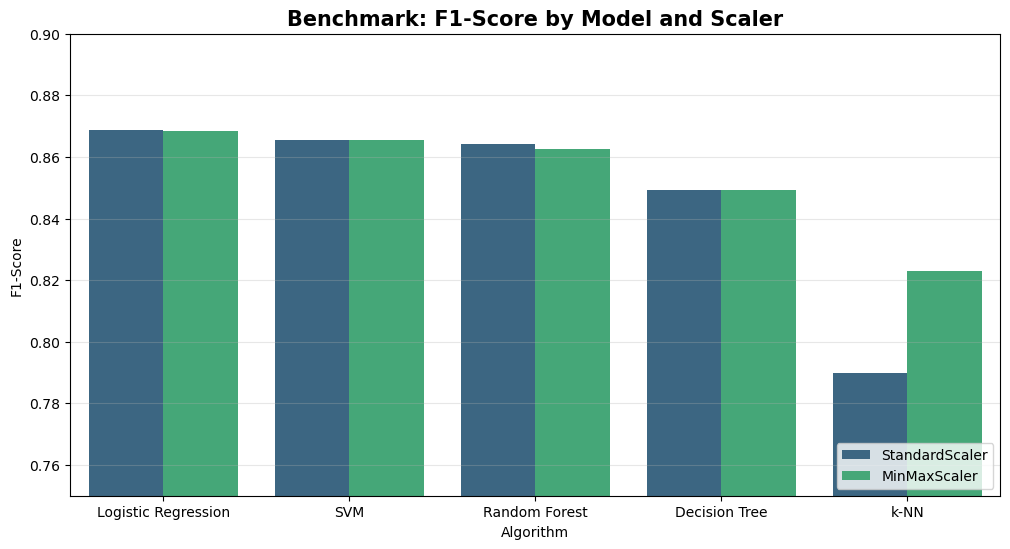

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
# On exclut Naive Bayes car il écrase le graphique vers le bas
df_plot = df_results[df_results['Model'] != 'Naive Bayes']

sns.barplot(data=df_plot, x='Model', y='F1', hue='Scaler', palette='viridis')
plt.ylim(0.75, 0.90) # Zoom sur les bons scores
plt.title('Benchmark: F1-Score by Model and Scaler', fontsize=15, fontweight='bold')
plt.ylabel('F1-Score')
plt.xlabel('Algorithm')
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.show()

### Benchmark Results Analysis

After training 6 different algorithms with two types of scaling techniques (StandardScaler and MinMaxScaler), we obtained the following results:

**1. Top Performer: Logistic Regression**
*   **Performance:** The **Logistic Regression** (coupled with StandardScaler) achieved the best overall performance with an **Accuracy of 84.45%** and an **F1-Score of 0.8688**.
*   **Interpretation:** The fact that a linear model outperforms complex non-linear models (like KNN) suggests that the decision boundary between "Depressed" and "Not Depressed" students is relatively linear in the high-dimensional space created by our encoding.
*   **ROC-AUC:** It also achieved the highest ROC-AUC score (0.9181), confirming its excellent ability to rank positive cases correctly.

**2. Runner-ups: SVM and Random Forest**
*   **SVM:** Performed almost identically to Logistic Regression (F1: 0.8655) but required significantly more computational time (over 10 minutes vs. seconds for LogReg).
*   **Random Forest:** Very stable performance (F1: 0.8641), closely following the leaders. It remains a strong candidate due to its interpretability and resistance to overfitting.

**3. The Failure of Naive Bayes**
*   Gaussian Naive Bayes failed completely (Recall: 0.18%). It likely suffered from the violation of the independence assumption caused by the One-Hot Encoding of categorical variables (e.g., City_Agra and City_Pune are mutually exclusive, not independent).

**4. Impact of Scaling**
*   **Tree-based models (RF, DT):** As expected theoretically, scaling had zero impact on their performance.
*   **Distance-based models (k-NN):** Showing a strong preference for **MinMaxScaler** (+3.3% F1-score boost compared to StandardScaler).

**Conclusion & Selection:**
For the next steps (optimization), we will select **Logistic Regression** as our primary model due to its speed and top performance. We will also keep **Random Forest** as a challenger to see if hyperparameter tuning can help it surpass the linear baseline.